# To Design a CNN model to classify color image dataset(Built from scratch) with pytorch framework.  Compute performance metrics and test the model through visualization of test results. Plot intermediate features and save the model. 

# Load the dataset from Kaggle API

# Step 1: Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns # Plotting

# Step 2: Load and Preprocess the Dataset

In [2]:
# Define transforms
train_path = 'C:/Users/Dr.PVVK/.cache/kagglehub/datasets/karimabdulnabi/fruit-classification10-class/versions/1/MY_data/train'
test_path = 'C:/Users/Dr.PVVK/.cache/kagglehub/datasets/karimabdulnabi/fruit-classification10-class/versions/1/MY_data/test'
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.dataset.classes
print(f"Classes: {class_names}")

Classes: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


In [3]:
# Iterate over the DataLoader
for images, labels in train_loader:
    print(f"Image batch size: {images.size()}")  # Batch size and dimensions
    print(f"Labels batch size: {labels.size()}")  # Batch size of labels
    break  # Check only the first batch

# Dataset size
dataset_size = len(train_loader.dataset)
print(f"Dataset size: {dataset_size}")

Image batch size: torch.Size([32, 3, 150, 150])
Labels batch size: torch.Size([32])
Dataset size: 1840


In [4]:
print(labels)

tensor([3, 4, 7, 0, 9, 0, 0, 9, 4, 8, 4, 6, 1, 2, 7, 8, 1, 9, 0, 8, 9, 3, 6, 1,
        1, 3, 3, 7, 9, 3, 6, 8])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)  # Move to the same device as the model
print(device)

cuda


# Step 3: Define the CNN Model

In [7]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten_size = None  # Will compute dynamically
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 128),  # Placeholder
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.classifier[0] = nn.Linear(self.flatten_size, 128).to(x.device)  # Adjust dynamically
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Step 4: Define Training and Evaluation Functions

In [8]:

# Move the model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNClassifier(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

In [9]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(loader), accuracy

# Step 5: Train the Model

In [10]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNClassifier(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Ensure data is on the same device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
print(images.device)  # Should print 'cuda:0' if using GPU
print(labels.device)  # Should match the device of the model
#print(model.device)

In [ ]:
print(images.device)               # Should print 'cuda:0' or 'cpu'
print(next(model.parameters()).device)  # Should match


In [ ]:
print(labels.min(), labels.max())  # Should be within 0 to num_classes - 1


In [11]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{10} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1/10 - Loss: 1.3836, Accuracy: 0.4826
Epoch 2/10 - Loss: 1.3355, Accuracy: 0.5016
Epoch 3/10 - Loss: 1.3255, Accuracy: 0.4902
Epoch 4/10 - Loss: 1.3065, Accuracy: 0.5114
Epoch 5/10 - Loss: 1.2800, Accuracy: 0.5337
Epoch 6/10 - Loss: 1.2399, Accuracy: 0.5408
Epoch 7/10 - Loss: 1.2246, Accuracy: 0.5565
Epoch 8/10 - Loss: 1.2005, Accuracy: 0.5549
Epoch 9/10 - Loss: 1.2200, Accuracy: 0.5560
Epoch 10/10 - Loss: 1.1991, Accuracy: 0.5603


In [12]:
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Compute training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Compute validation metrics
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        # Print progress for the epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [13]:
train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, device)

Epoch [1/10] - Train Loss: 1.1629, Train Accuracy: 0.5696, Val Loss: 1.3384, Val Accuracy: 0.5033
Epoch [2/10] - Train Loss: 1.1308, Train Accuracy: 0.5875, Val Loss: 1.2675, Val Accuracy: 0.5618
Epoch [3/10] - Train Loss: 1.1309, Train Accuracy: 0.5962, Val Loss: 1.3074, Val Accuracy: 0.5488
Epoch [4/10] - Train Loss: 1.1480, Train Accuracy: 0.5804, Val Loss: 1.2654, Val Accuracy: 0.5488
Epoch [5/10] - Train Loss: 1.1176, Train Accuracy: 0.5864, Val Loss: 1.3145, Val Accuracy: 0.5358
Epoch [6/10] - Train Loss: 1.1344, Train Accuracy: 0.5886, Val Loss: 1.2780, Val Accuracy: 0.5618
Epoch [7/10] - Train Loss: 1.0883, Train Accuracy: 0.6114, Val Loss: 1.2548, Val Accuracy: 0.5618
Epoch [8/10] - Train Loss: 1.0826, Train Accuracy: 0.5918, Val Loss: 1.2328, Val Accuracy: 0.5748
Epoch [9/10] - Train Loss: 1.0667, Train Accuracy: 0.6158, Val Loss: 1.3117, Val Accuracy: 0.5228
Epoch [10/10] - Train Loss: 1.0662, Train Accuracy: 0.6152, Val Loss: 1.2644, Val Accuracy: 0.5531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


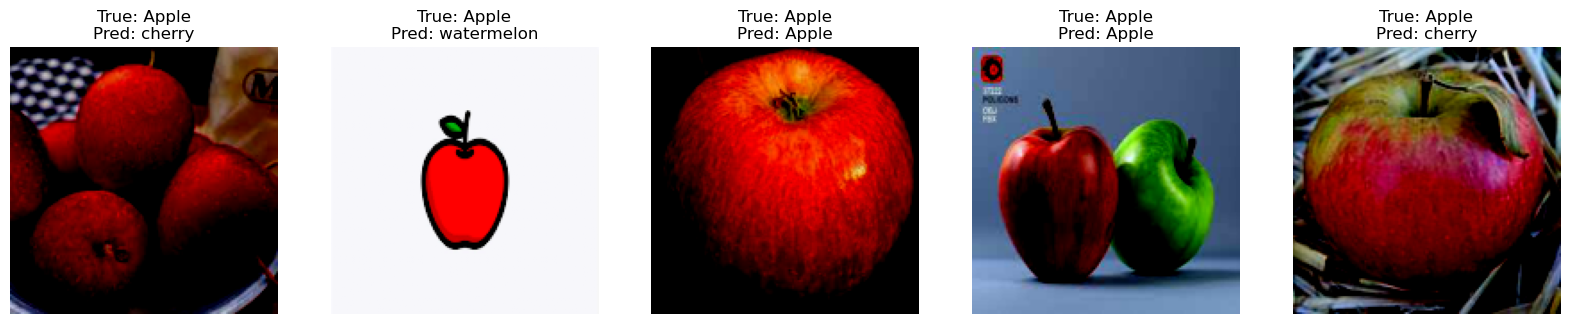

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def test_and_visualize(model, test_loader, device, class_mapping):
    # Set the model to evaluation mode
    model.eval()
    
    # Sample a few test images and corresponding labels
    images, labels = next(iter(test_loader))  # Take a batch from the test set
    images, labels = images.to(device), labels.to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(images)

    # Get predicted labels
    _, preds = torch.max(outputs, 1)

    # Convert class labels from integers to strings (if necessary)
    inv_class_mapping = {v: k for k, v in class_mapping.items()}  # Inverse mapping
    true_labels = [inv_class_mapping[label.item()] for label in labels]
    pred_labels = [inv_class_mapping[pred.item()] for pred in preds]

    # Plot a few images along with true and predicted labels
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Display 5 images
    for i, ax in enumerate(axes):
        ax.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Convert tensor to image
        ax.set_title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        ax.axis('off')
    
    plt.show()

# Example usage
class_mapping = {
    'Apple': 0,
    'Banana': 1,
    'avocado': 2,
    'cherry': 3,
    'kiwi': 4,
    'mango': 5,
    'orange': 6,
    'pinenapple': 7,
    'strawberries': 8,
    'watermelon': 9
}
test_and_visualize(model, test_loader, device, class_mapping)

In [15]:
print(model)

CNNClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=36992, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


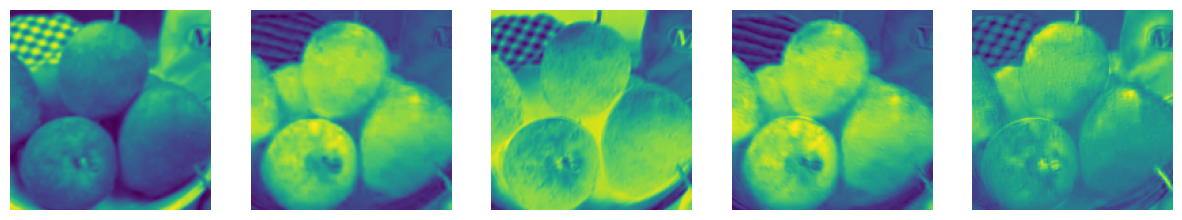

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Hook function to capture the output of a layer
def hook_fn(module, input, output):
    # Store the output (activations) of the layer
    features.append(output)

# List to store feature maps
features = []

# Register the hook on the desired convolutional layer (e.g., first conv layer)
conv_layer = model.features[0]  # Access the first Conv2d layer in 'features'
hook = conv_layer.register_forward_hook(hook_fn)

def visualize_intermediate_features(model, test_loader, device, num_images=5):
    # Set the model to evaluation mode
    model.eval()
    
    # Get a few test images and labels
    images, labels = next(iter(test_loader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    # Perform a forward pass to get feature maps
    with torch.no_grad():
        _ = model(images)

    # Now features will contain the activations from the registered layer
    feature_map = features[0]  # Extract the feature map from the hook

    # Number of feature maps in the layer
    num_feature_maps = feature_map.size(1)  # [batch_size, num_feature_maps, height, width]
    
    # Plot the feature maps of the first image in the batch
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(feature_map[0, i].cpu().numpy(), cmap='viridis')  # Visualize each feature map
        ax.axis('off')
    plt.show()

    # Remove the hook after use
    hook.remove()

# Example usage
visualize_intermediate_features(model, test_loader, device)

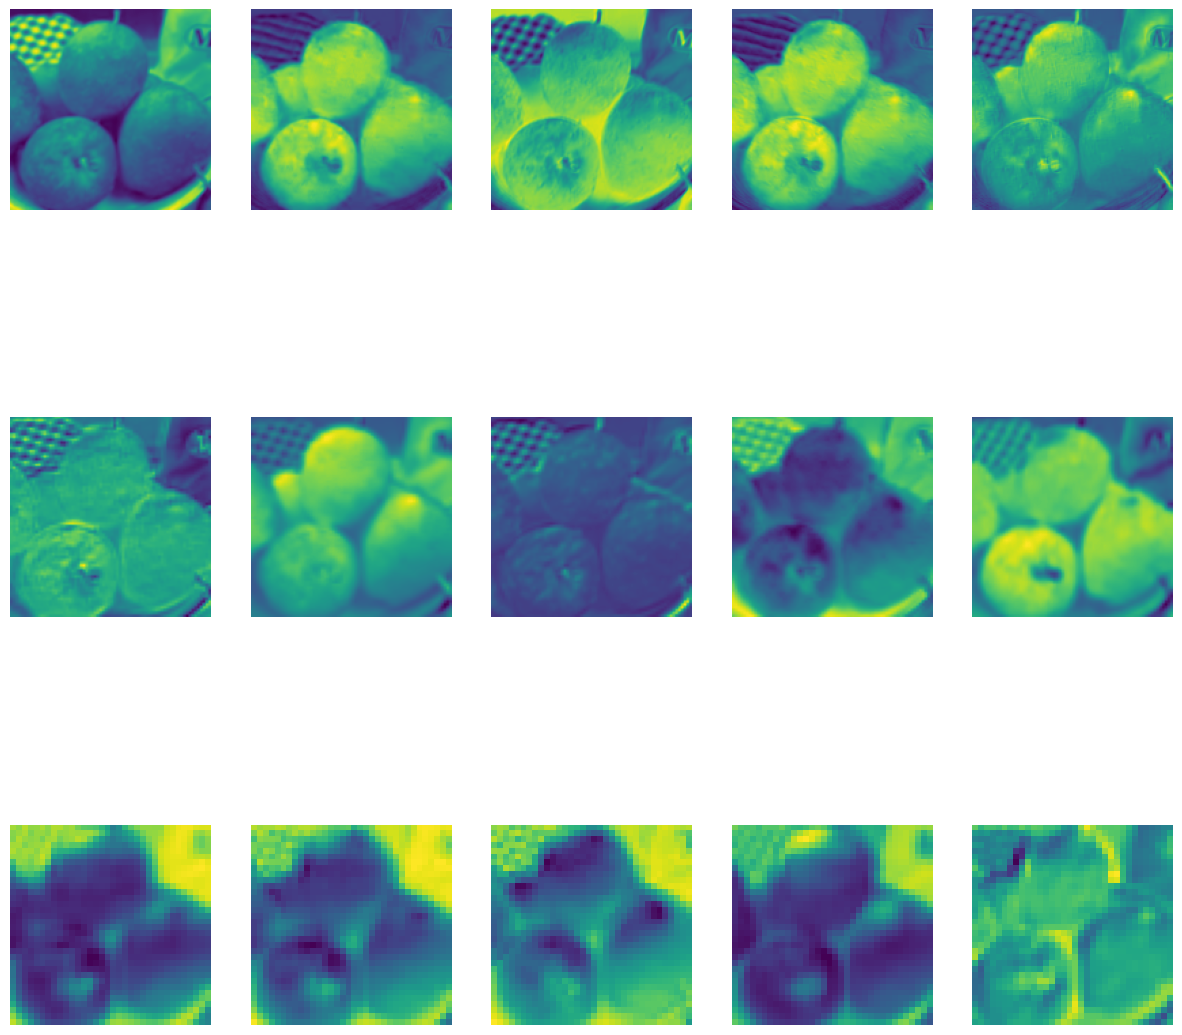

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Hook function to capture the output of a layer
def hook_fn(module, input, output):
    # Store the output (activations) of the layer
    features.append(output)

# List to store feature maps
features = []

# Register hooks on all convolutional layers in the 'features' block
hook_handles = []
for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.Conv2d):  # Register hook only on Conv2d layers
        hook = layer.register_forward_hook(hook_fn)
        hook_handles.append(hook)

def visualize_intermediate_features(model, test_loader, device, num_images=5):
    # Set the model to evaluation mode
    model.eval()
    
    # Get a few test images and labels
    images, labels = next(iter(test_loader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    # Perform a forward pass to get feature maps
    with torch.no_grad():
        _ = model(images)

    # Now features will contain the activations from all registered layers
    num_layers = len(features)  # Number of layers with hooks
    fig, axes = plt.subplots(num_layers, num_images, figsize=(15, 15))
    
    # Plot feature maps for each layer
    for layer_idx in range(num_layers):
        feature_map = features[layer_idx]  # Extract the feature map from the layer
        num_feature_maps = feature_map.size(1)  # [batch_size, num_feature_maps, height, width]
        
        # Plot the feature maps of the first image in the batch
        for i in range(num_images):
            ax = axes[layer_idx, i]
            ax.imshow(feature_map[0, i].cpu().numpy(), cmap='viridis')  # Visualize each feature map
            ax.axis('off')
        
        # Add a label for the layer
        axes[layer_idx, 0].set_ylabel(f"Layer {layer_idx+1}", rotation=0, labelpad=15)
    
    plt.show()

    # Remove hooks after use
    for hook in hook_handles:
        hook.remove()

# Example usage
visualize_intermediate_features(model, test_loader, device)

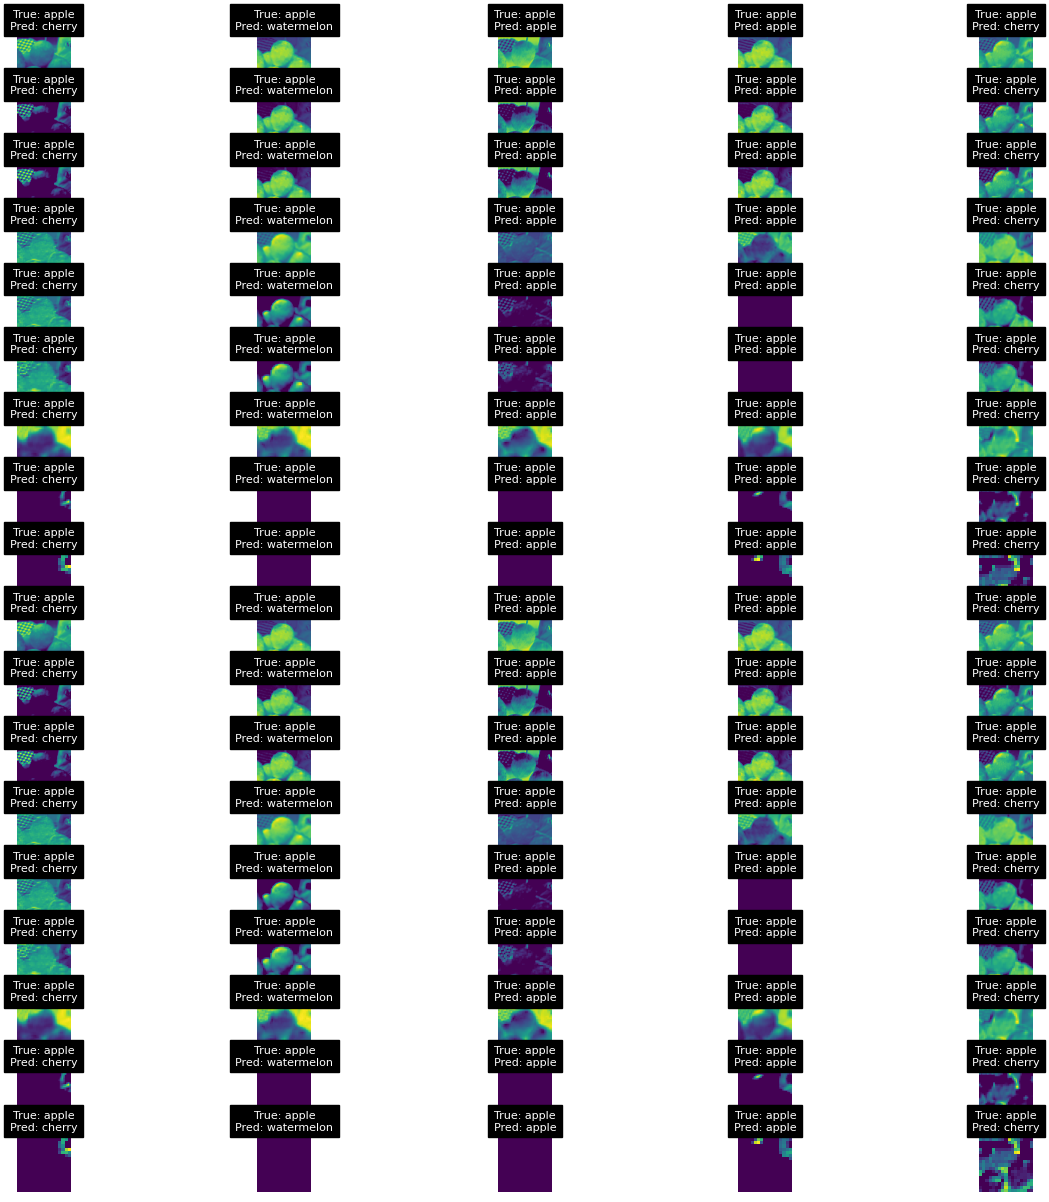

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Hook function to capture the output of a layer
def hook_fn(module, input, output):
    # Store the output (activations) of the layer
    features.append(output)

# List to store feature maps
features = []

# Register hooks on all layers in the 'features' block (Conv2d, ReLU, MaxPool2d)
hook_handles = []
for i, layer in enumerate(model.features):
    hook = layer.register_forward_hook(hook_fn)  # Register hook for every layer
    hook_handles.append(hook)

def visualize_intermediate_features(model, test_loader, device, num_images=5):
    # Set the model to evaluation mode
    model.eval()

    # Get a batch of test images and labels
    images, labels = next(iter(test_loader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the predicted class labels

    # Perform a forward pass to get feature maps
    with torch.no_grad():
        _ = model(images)

    # Now features will contain the activations from all registered layers
    num_layers = len(features)  # Number of layers with hooks
    fig, axes = plt.subplots(num_layers, num_images, figsize=(15, 15))
    
    # Plot feature maps for each layer
    for layer_idx in range(num_layers):
        feature_map = features[layer_idx]  # Extract the feature map from the layer
        num_feature_maps = feature_map.size(1)  # [batch_size, num_feature_maps, height, width]
        
        # Plot the feature maps of the first image in the batch
        for i in range(num_images):
            ax = axes[layer_idx, i]
            ax.imshow(feature_map[0, i].cpu().numpy(), cmap='viridis')  # Visualize each feature map
            ax.axis('off')

            # Display the true and predicted labels on the image
            true_label = test_loader.dataset.classes[labels[i].item()]
            pred_label = test_loader.dataset.classes[preds[i].item()]
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8, color='white', backgroundcolor='black')
        
        # Add a label for the layer
        axes[layer_idx, 0].set_ylabel(f"Layer {layer_idx+1}", rotation=0, labelpad=15)

    plt.show()

    # Remove hooks after use
    for hook in hook_handles:
        hook.remove()

# Example usage
visualize_intermediate_features(model, test_loader, device)


Classification Report:
              precision    recall  f1-score   support

       apple     0.5846    0.4270    0.4935        89
     avocado     0.0550    0.0571    0.0561       105
      banana     0.0654    0.0943    0.0772       106
      cherry     0.4531    0.8286    0.5859       105
        kiwi     0.5909    0.6190    0.6047       105
       mango     0.4940    0.3905    0.4362       105
      orange     0.8511    0.8247    0.8377        97
  pinenapple     0.7812    0.7143    0.7463       105
 stawberries     0.4643    0.2524    0.3270       103
  watermelon     0.7015    0.4476    0.5465       105

    accuracy                         0.4634      1025
   macro avg     0.5041    0.4656    0.4711      1025
weighted avg     0.4998    0.4634    0.4678      1025

Accuracy: 0.4634


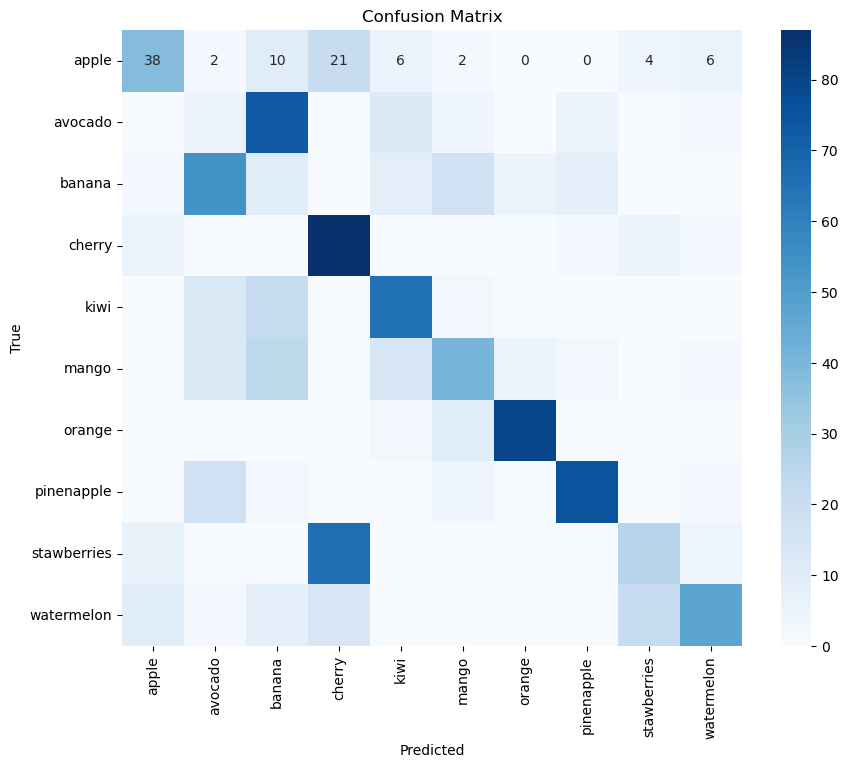

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Compute other metrics
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes, digits=4)
    
    print("Classification Report:")
    print(class_report)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Display confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
evaluate_model(model, test_loader, device)


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def compute_performance_metrics(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class labels
            
            # Collect true labels and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate other metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')  # weighted for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(cm, test_loader.dataset.classes)

def plot_confusion_matrix(cm, class_names):
    """
    This function visualizes the confusion matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Example usage
compute_performance_metrics(model, test_loader, device)
